## Clustering - Tarea Individual

### Entrega 13/11 a correo marcelo.medel.v@gmail.com.

1 .- (20%) Del código de K-means entregado como ejemplo a continuación, desarrolle: 

* Defina con un nombre cada uno de los segmentos (clusters) encontrados en la data.
* Ejecute el modelo con k=4, ¿cómo se llamaría el nuevo segmento definido?
* ¿Cómo y para qué se utilizan los métodos deSilhouette Score y Calinski Harabrasz?

2 .- (40%) Implemente el código para Hierarchical Agglomerative Clustering (**HAC**), puede reutilizar el código del ejemplo de kaggle. 

* Ejemplo: https://www.kaggle.com/hellbuoy/online-retail-k-means-hierarchical-clustering/notebook
* ¿Cuáles son las principales diferencias entre Single, Complete y Average Linkage en **HAC**?
* ¿Qué tan diferentes son los resultados entre ambos métodos K-means vs HAC?
    * ¿Los clientes quedan categorizados en el mismo cluster u en otro? 
    * ¿Hay diferencias en el tiempo de ejecución?
  
3 .- (40%) Implemente la detección de outliers en el dataframe `rfm` con DBSCAN, siguiendo los ejemplos de los links siguientes. 
* Ejemplo: http://exponentis.es/ejemplo-de-uso-de-dbscan-en-python-para-deteccion-de-outliers
* Ejemplo: https://www.datatechnotes.com/2020/04/anomaly-detection-with-dbscan-in-python.html
* ¿Qué tan diferentes son los resultados respecto a la detección de outliers utilizando ***interquartile range***?

     


# Ejemplo de RFM y K-means

## Data Preprocessing

* Cargamos los datos
* Se eliminan valores nulos
* Se cambia el tipo de datos de customerID
* Se crean nuevos atributos de RFM. 
    * https://medium.com/@hhuseyincosgun/customer-segmentation-rfm-analysis-recency-frequency-monetary-5b29d5d45e35
* Detección y filtraje de outliers para los nuevos atributos creados
* Se realiza un escalamiento de los datos. 


In [258]:
!pip install missingno

In [259]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import missingno as msno


In [260]:
retail = pd.read_csv('./data/OnlineRetail.csv', sep=";", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 8:26,"2,55",17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 8:26,"3,39",17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 8:26,"2,75",17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 8:26,"3,39",17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 8:26,"3,39",17850.0,United Kingdom


In [261]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   UnitPrice    541910 non-null  object 
 6   CustomerID   406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


<Axes: >

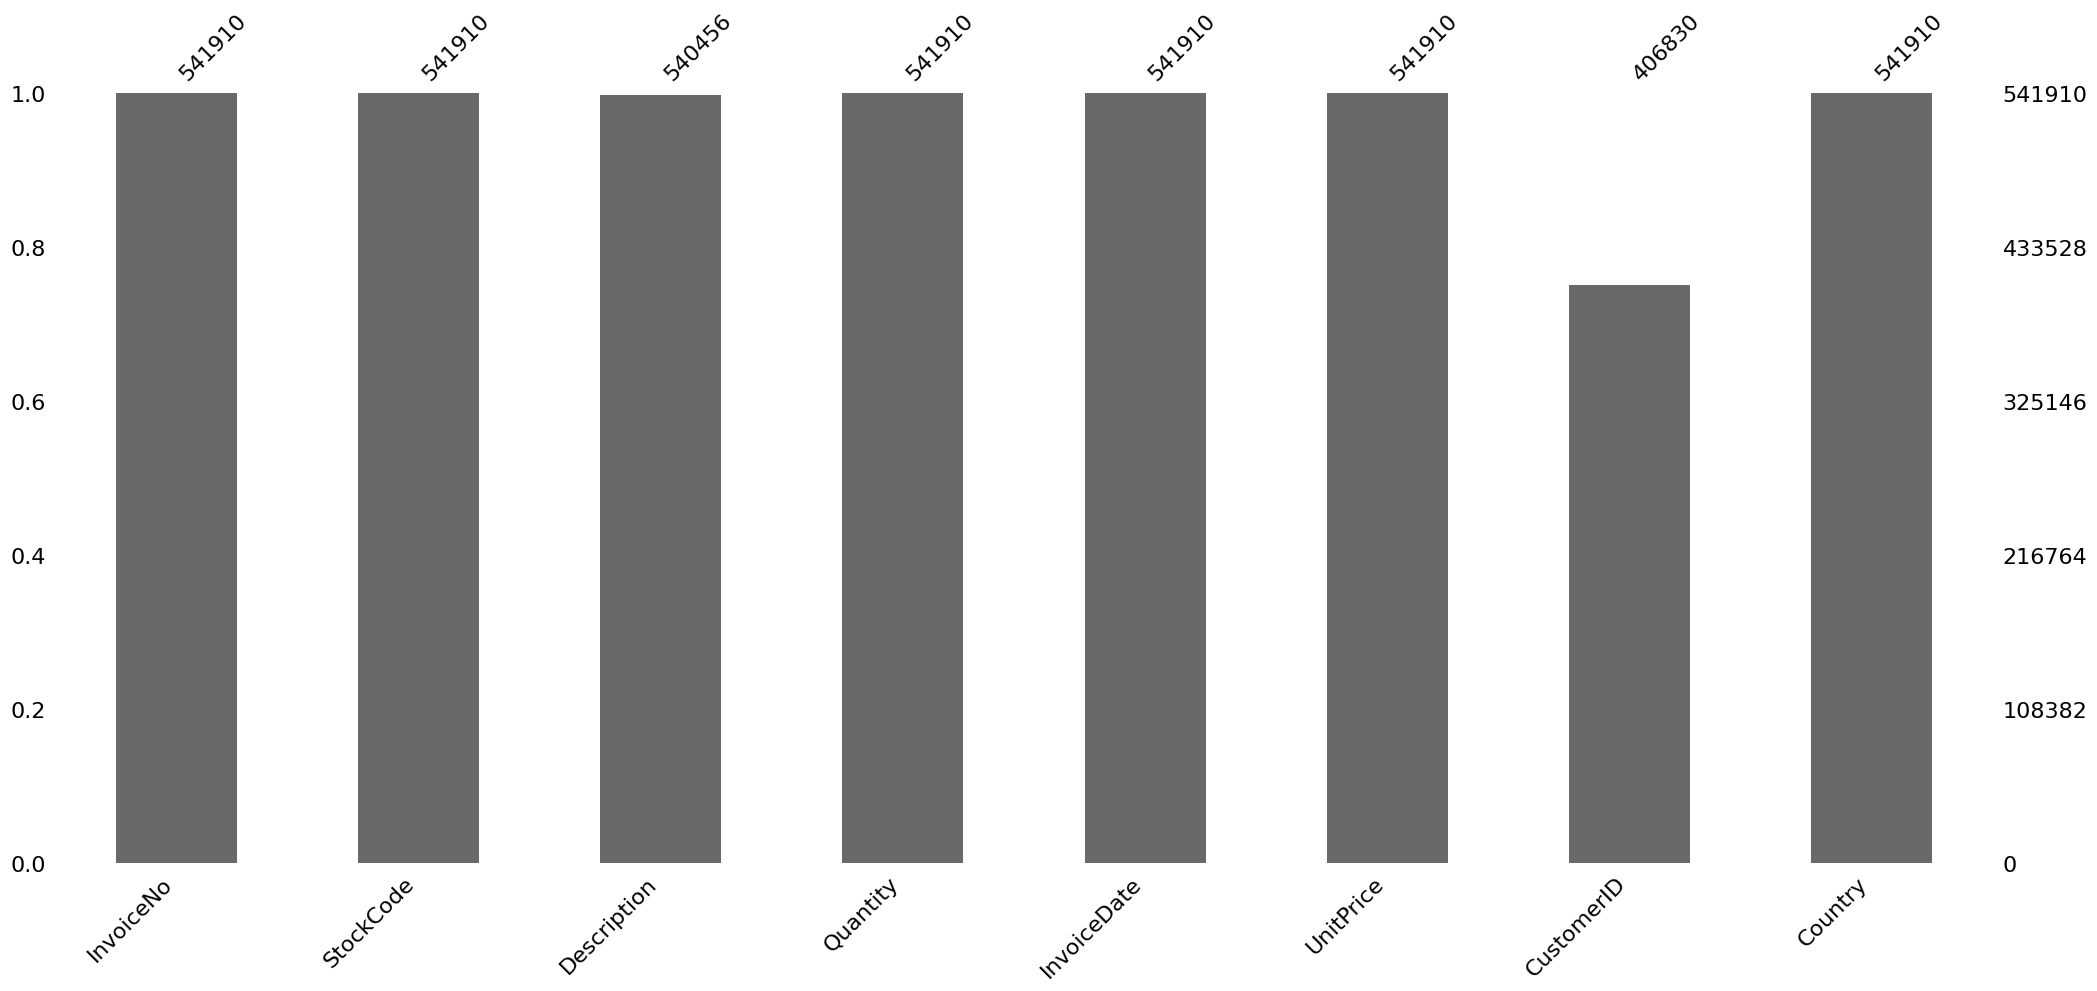

In [262]:
msno.bar(retail)

In [263]:
# Droping rows having missing values
retail = retail.dropna()

# Changing the datatype of Customer Id as per Business understanding
retail['CustomerID'] = retail['CustomerID'].astype(int).astype(str)

retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406830 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceNo    406830 non-null  object
 1   StockCode    406830 non-null  object
 2   Description  406830 non-null  object
 3   Quantity     406830 non-null  int64 
 4   InvoiceDate  406830 non-null  object
 5   UnitPrice    406830 non-null  object
 6   CustomerID   406830 non-null  object
 7   Country      406830 non-null  object
dtypes: int64(1), object(7)
memory usage: 27.9+ MB


In [264]:

# Reemplazar comas por puntos en las columnas 'Quantity' y 'UnitPrice'
retail['UnitPrice'] = retail['UnitPrice'].str.replace(',', '.').astype(float)
print(retail.dtypes)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object


In [265]:
## To do a RFM model we have to create 3 columns recency, frequency and monetary
## monetary = Quantity * UnitPrice

retail.columns = retail.columns.str.lower()
retail['monetary'] = retail['quantity'] * retail['unitprice']
retail['invoicedate'] = pd.to_datetime(retail['invoicedate'],format='%d-%m-%Y %H:%M')
retail['diff_days'] = (retail['invoicedate'].max() - retail['invoicedate']).dt.days

rfm = retail.groupby('customerid').agg({'diff_days': 'min', 'invoiceno':pd.Series.nunique, 'monetary': 'sum' }).reset_index()

rfm.columns = ['customerid', 'recency', 'frequency', 'monetary']

rfm.head()

,customerid,recency,frequency,monetary
0,12346,325,2,0.00
1,12347,1,7,4310.00
2,12348,74,4,1797.24
3,12349,18,1,1757.55
4,12350,309,1,334.40


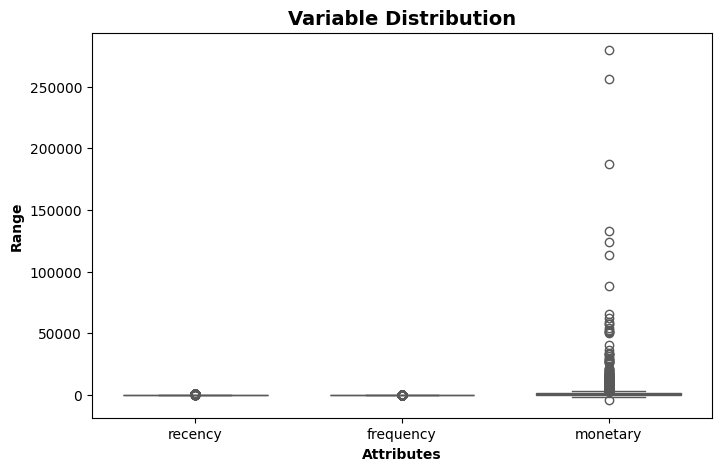

In [266]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['recency','frequency','monetary']
plt.rcParams['figure.figsize'] = [8,5]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.show()

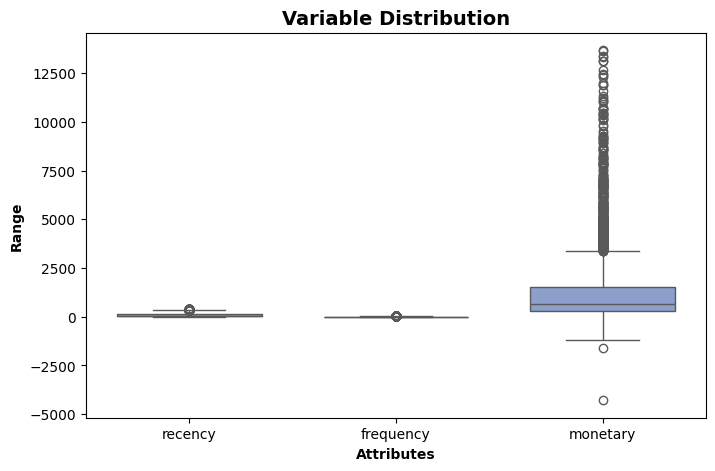

In [267]:
### Outlier Treatment using Interquantile range

def get_iqr(df,col):
    q1 = df[col].quantile(0.05)
    q3 = df[col].quantile(0.95)
    iqr = q3-q1
    return q1,q3,iqr

# Removing (statistical) outliers for Amount
col = 'monetary'
q1, q3, iqr = get_iqr(rfm,col)
rfm = rfm[(rfm[col] >= q1 - 1.5*iqr) & (rfm[col] <= q3 + 1.5*iqr)]

# Removing (statistical) outliers for Recency
col = 'recency'
q1, q3, iqr = get_iqr(rfm,col)
rfm = rfm[(rfm[col] >= q1 - 1.5*iqr) & (rfm[col] <= q1 + 1.5*iqr)]

# Removing (statistical) outliers for Frequency
col = 'frequency'
q1, q3, iqr = get_iqr(rfm,col)
rfm = rfm[(rfm[col] >= q1 - 1.5*iqr) & (rfm[col] <= q3 + 1.5*iqr)]

## ¿cuántos outliers removí?

attributes = ['recency','frequency','monetary']
plt.rcParams['figure.figsize'] = [8,5]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.show()

In [268]:
## Solo dejaremos valores positivos de monetary
rfm = rfm.query('monetary > 0').reset_index(drop=True)

In [269]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])
scaled.shape

scaled

rfm_scaled = pd.DataFrame(scaled)
rfm_scaled.columns = ['recency', 'frequency', 'monetary']
rfm_scaled.head()

,recency,frequency,monetary
0,-0.903887,0.575435,1.749769
1,-0.168771,-0.063870,0.297360
2,-0.732696,-0.703175,0.274418
3,2.197698,-0.703175,-0.548182
4,-0.561504,1.427842,0.151798


## KMeans

#### Se aplican distintos k con KMeans, se calculan la inercia, distorsión, Silhouette score y Calinski Harabrasz score para cada k.
### 

* https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [270]:
# Calinski Harabasz
from sklearn.metrics import calinski_harabasz_score as chs

# Silhouette score 
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

K = range(2,10)
distortions = []
inertias = []
sil_score = []
chs_score = []

for k in K:
    # intialise kmeans
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(rfm_scaled)
    
    distortions.append(sum(np.min(cdist(rfm_scaled, kmeans.cluster_centers_,
                                    'euclidean'), axis=1)) / rfm_scaled.shape[0])
    inertias.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
    sil_score.append(silhouette_score(rfm_scaled, cluster_labels))
    chs_score.append(chs(rfm_scaled,cluster_labels))


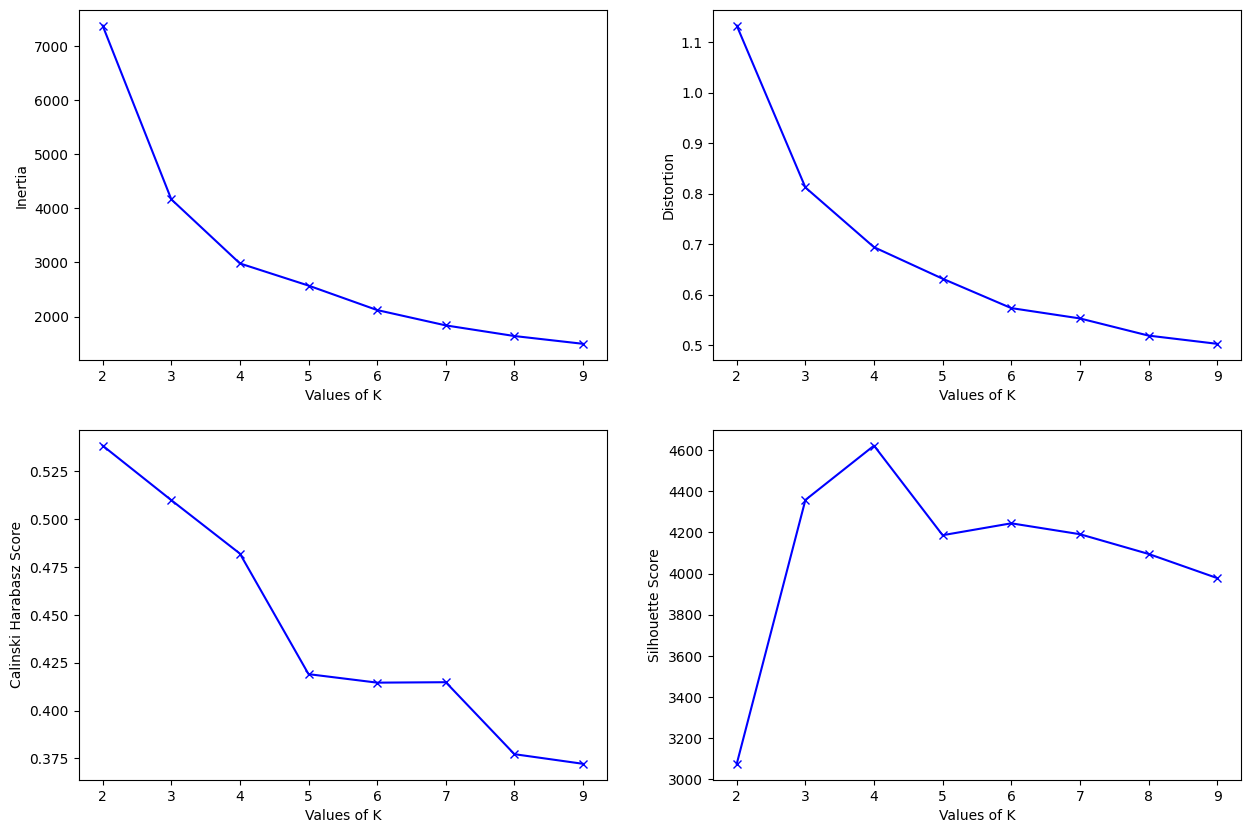

In [271]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
## Plot results

ax[0,0].plot(K, inertias, 'bx-')
ax[0,0].set_xlabel('Values of K')
ax[0,0].set_ylabel('Inertia')

ax[0,1].plot(K, distortions, 'bx-')
ax[0,1].set_xlabel('Values of K')
ax[0,1].set_ylabel('Distortion')

ax[1,0].plot(K, sil_score, 'bx-')
ax[1,0].set_xlabel('Values of K')
ax[1,0].set_ylabel('Calinski Harabasz Score')

ax[1,1].plot(K, chs_score, 'bx-')
ax[1,1].set_xlabel('Values of K')
ax[1,1].set_ylabel('Silhouette Score')

plt.show()

In [272]:
rfm.head()

,customerid,recency,frequency,monetary
0,12347,1,7,4310.00
1,12348,74,4,1797.24
2,12349,18,1,1757.55
3,12350,309,1,334.40
4,12352,35,11,1545.41


In [273]:
rfm_scaled.head()

,recency,frequency,monetary
0,-0.903887,0.575435,1.749769
1,-0.168771,-0.063870,0.297360
2,-0.732696,-0.703175,0.274418
3,2.197698,-0.703175,-0.548182
4,-0.561504,1.427842,0.151798


In [274]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_scaled)

KMeans(max_iter=50, n_clusters=3)

In [275]:
# assign the label
rfm['cluster_id'] = kmeans.labels_
rfm.head()

,customerid,recency,frequency,monetary,cluster_id
0,12347,1,7,4310.00,2
1,12348,74,4,1797.24,0
2,12349,18,1,1757.55,0
3,12350,309,1,334.40,1
4,12352,35,11,1545.41,0


### Graficamos los clusters utilizando 2 dimensiones.

* https://www.kaggle.com/dhanyajothimani/basic-visualization-and-clustering-in-python

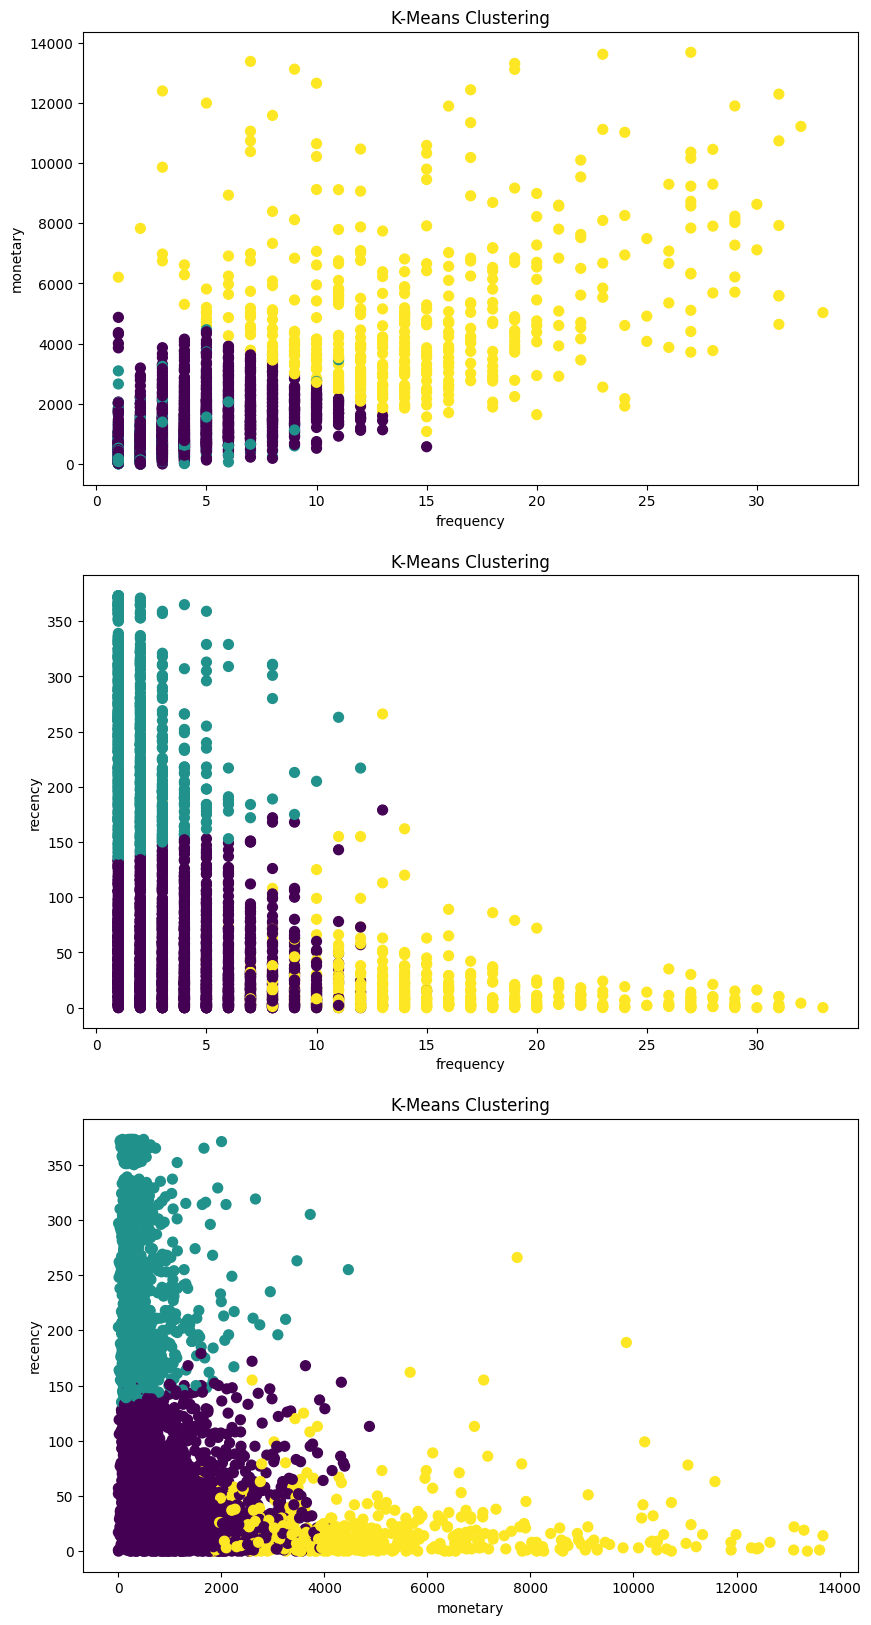

In [276]:
#Plot the clusters obtained using k means

fig, ax = plt.subplots(3,1,figsize=(10,20))
ax[0].scatter(rfm['frequency'],rfm['monetary'],c=rfm['cluster_id'],s=50)
ax[0].set_title('K-Means Clustering')
ax[0].set_xlabel('frequency')
ax[0].set_ylabel('monetary')
#plt.colorbar(scatter)

#Plot the clusters obtained using k means

ax[1].scatter(rfm['frequency'],rfm['recency'],c=rfm['cluster_id'],s=50)
ax[1].set_title('K-Means Clustering')
ax[1].set_xlabel('frequency')
ax[1].set_ylabel('recency')

#Plot the clusters obtained using k means
ax[2].scatter(rfm['monetary'],rfm['recency'],c=rfm['cluster_id'],s=50)
ax[2].set_title('K-Means Clustering')
ax[2].set_xlabel('monetary')
ax[2].set_ylabel('recency')

plt.show()

### Otra forma de visualizar lo mismo

<Axes: xlabel='cluster_id', ylabel='frequency'>

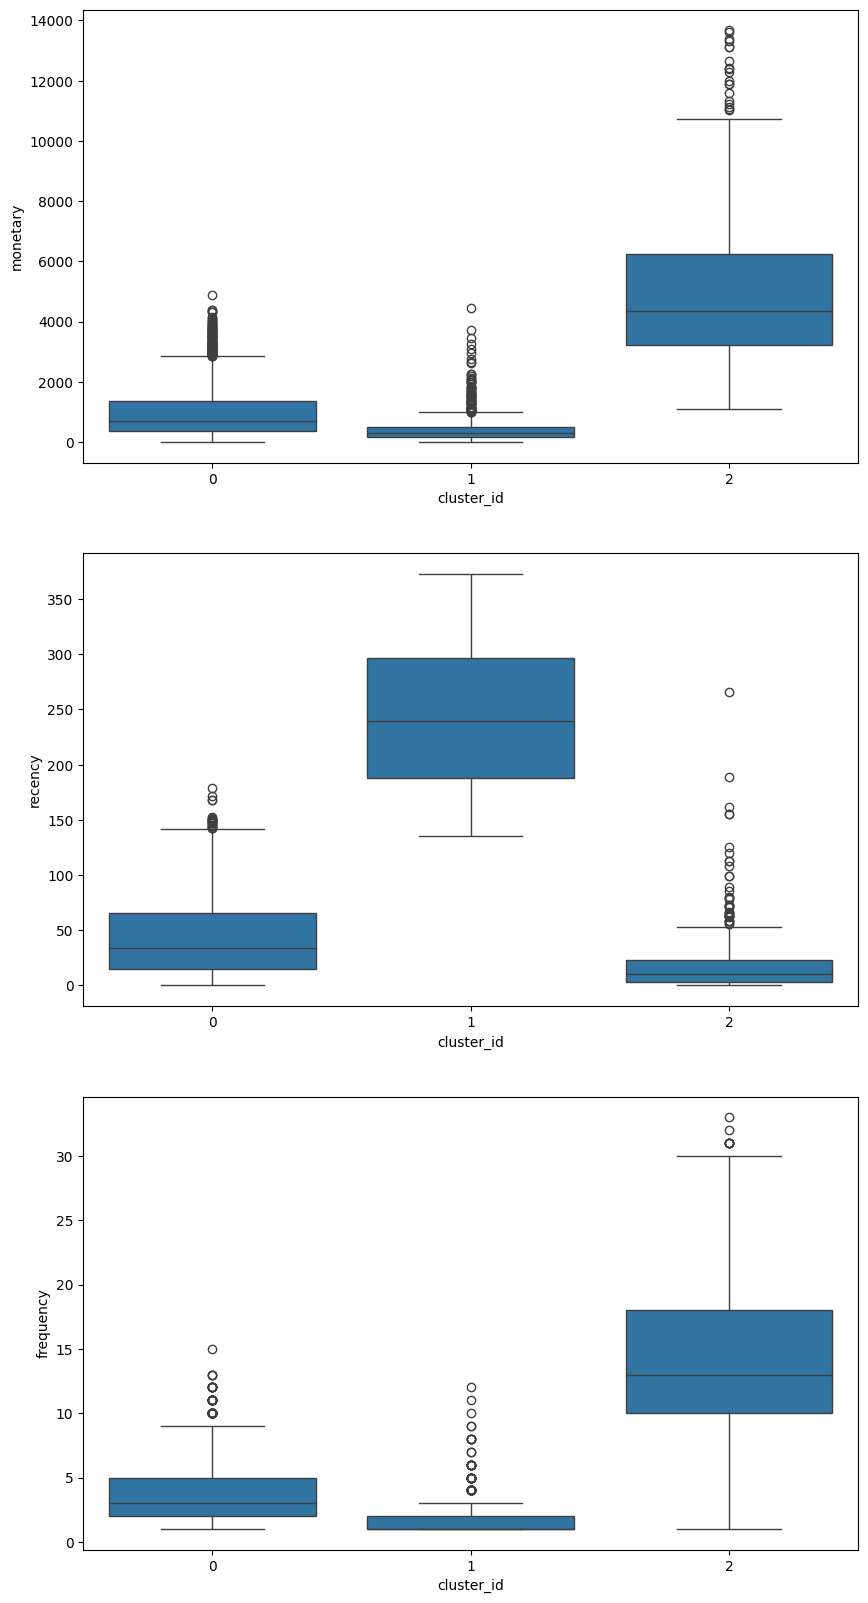

In [277]:
fig, ax = plt.subplots(3,1,figsize=(10,20))

sns.boxplot(x='cluster_id', y='monetary', data=rfm, ax=ax[0])
sns.boxplot(x='cluster_id', y='recency', data=rfm, ax=ax[1])
sns.boxplot(x='cluster_id', y='frequency', data=rfm, ax=ax[2])

1 .- (20%) Del código de K-means entregado como ejemplo a continuación, desarrolle: 

* Defina con un nombre cada uno de los segmentos (clusters) encontrados en la data.

In [278]:
rfm.head()

,customerid,recency,frequency,monetary,cluster_id
0,12347,1,7,4310.00,2
1,12348,74,4,1797.24,0
2,12349,18,1,1757.55,0
3,12350,309,1,334.40,1
4,12352,35,11,1545.41,0


In [279]:
# Calcular estadísticas por cluster agrupando por cluster_id y calculando la media de recency, frequency y monetary
rfm.groupby('cluster_id').agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean'}).reset_index()



,cluster_id,recency,frequency,monetary
0,0,44.062546,3.515728,966.195583
1,1,245.349328,1.745681,421.909080
2,2,19.365385,14.566239,5049.038397


# Estableciendo nombre para los cluster N=3

* Analizando el promedio de recency, recency y monetary, ademas tomando en cuenta los gráficos de caja podemos ver las siguientes categorias 

* Cluster 0: "Clientes Promedio"
Recency: 43.88 días (moderadamente reciente).
Frequency: 3.55 compras (ocasionales).
Monetary: 979.32 (gasto moderado).
Por lo que vemos son clientes típicos, con una actividad y gasto intermedios, lo que los hace clientes promedio.

* Cluster 1: "Clientes Inactivos"
Recency: 245.03 días (hace mucho tiempo que compraron).
Frequency: 1.74 compras (muy baja frecuencia).
Monetary: 421.19 (bajo gasto total).
Son clientes que han comprado poco y no han regresado recientemente, posiblemente porque no tienen interes.

* Cluster 2: "Clientes VIP"
Recency: 19.02 días (muy recientes).
Frequency: 14.76 compras (alta frecuencia).
Monetary: 5119.07 (gasto muy alto).
Son clientes destacados que compran frecuentemente, han hecho compras recientes y tienen un alto valor monetario.

In [280]:
cluster_names = {
    0: "Clientes Promedio", #Clientes moderadamente recientes, con frecuencia y gasto moderados.	
    1: "Clientes Inactivos",#Clientes inactivos, con recencia, frecuencia y gasto bajos.
    2: "Clientes VIP", #Clientes recientes, con frecuencia y gasto altos.
}
rfm['cluster_name'] = rfm['cluster_id'].map(cluster_names)

In [281]:
rfm.head()

,customerid,recency,frequency,monetary,cluster_id,cluster_name
0,12347,1,7,4310.00,2,Clientes VIP
1,12348,74,4,1797.24,0,Clientes Promedio
2,12349,18,1,1757.55,0,Clientes Promedio
3,12350,309,1,334.40,1,Clientes Inactivos
4,12352,35,11,1545.41,0,Clientes Promedio


# Creamos grafico de burubujas asi podemos validar que nuestras categorias hacen sentido con comportamiento de los datos recency, frecuency y monetary

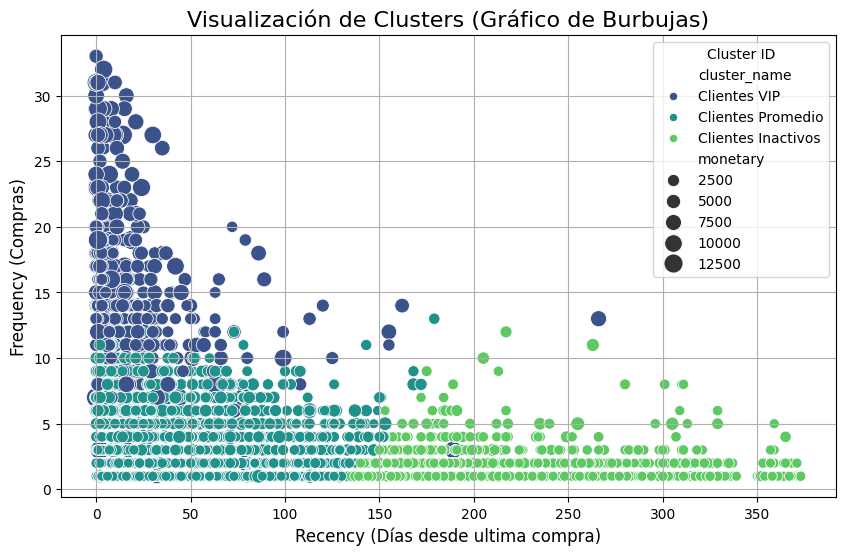

In [282]:
# Crear gráfico de burbujas
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm,
    x='recency',
    y='frequency',
    size='monetary',
    hue='cluster_name',
    palette='viridis',
    sizes=(50, 200),  #
    legend='brief'
)

# Etiquetas y título
plt.title('Visualización de Clusters (Gráfico de Burbujas)', fontsize=16)
plt.xlabel('Recency (Días desde ultima compra)', fontsize=12)
plt.ylabel('Frequency (Compras)', fontsize=12)
plt.legend(title='Cluster ID', fontsize=10, loc='upper right')
plt.grid(True)
plt.show()

* Ejecute el modelo con k=4, ¿cómo se llamaría el nuevo segmento definido?


In [283]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_scaled)

KMeans(max_iter=50, n_clusters=4)

In [284]:
# assign the label
rfm['cluster_id'] = kmeans.labels_
rfm.head()

,customerid,recency,frequency,monetary,cluster_id,cluster_name
0,12347,1,7,4310.00,1,Clientes VIP
1,12348,74,4,1797.24,2,Clientes Promedio
2,12349,18,1,1757.55,2,Clientes Promedio
3,12350,309,1,334.40,0,Clientes Inactivos
4,12352,35,11,1545.41,1,Clientes Promedio


Text(0, 0.5, 'recency')

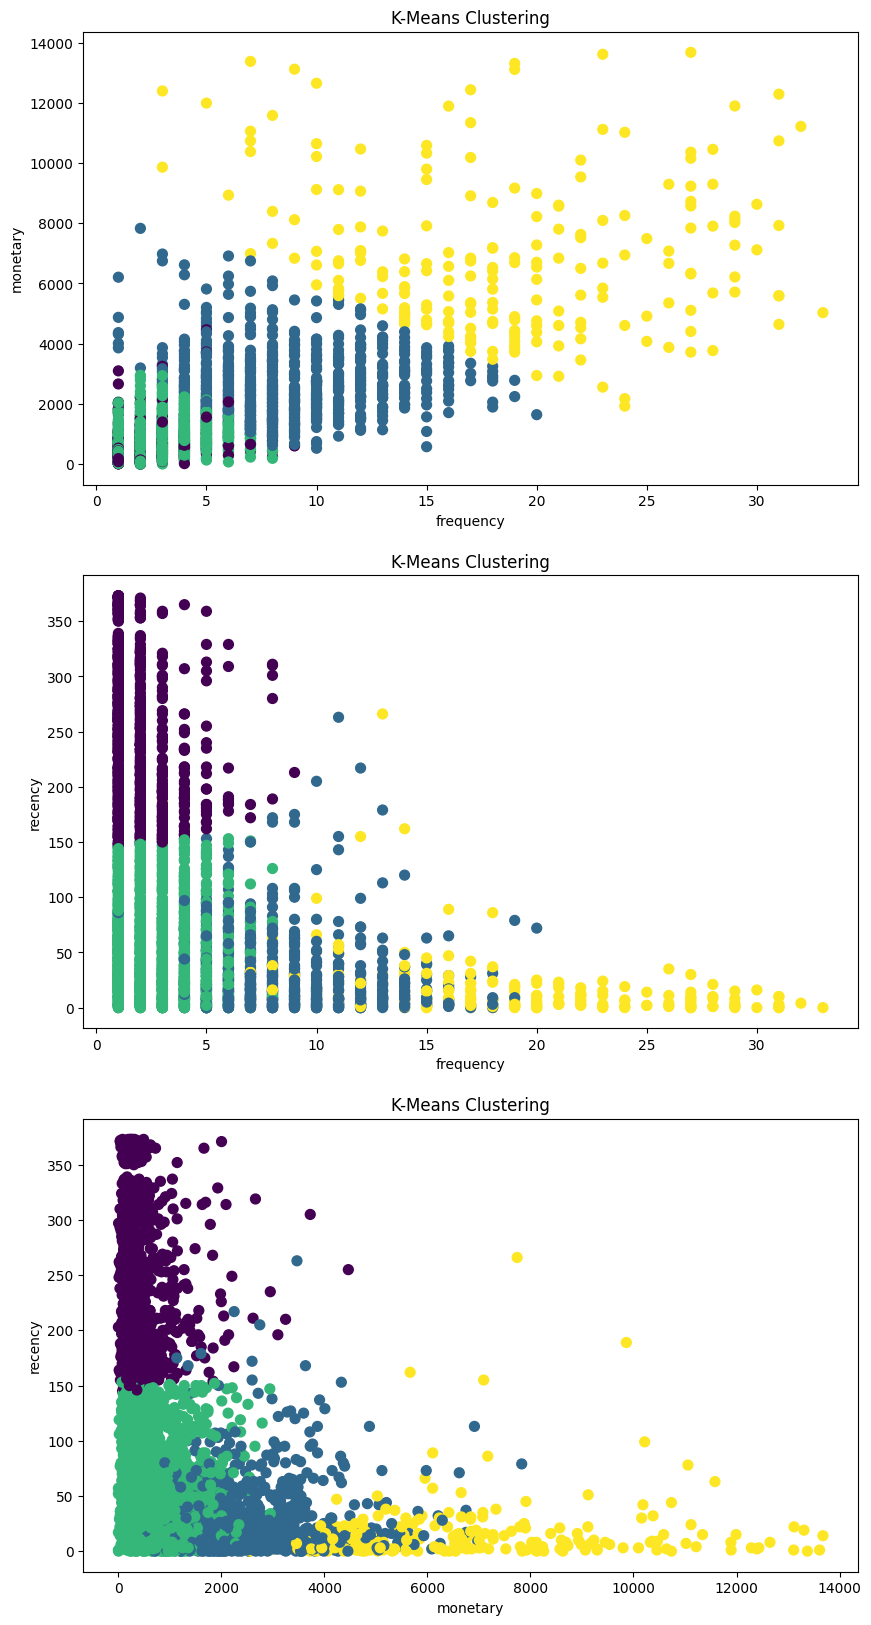

In [285]:
#Plot the clusters obtained using k means

fig, ax = plt.subplots(3,1,figsize=(10,20))
ax[0].scatter(rfm['frequency'],rfm['monetary'],c=rfm['cluster_id'],s=50)
ax[0].set_title('K-Means Clustering')
ax[0].set_xlabel('frequency')
ax[0].set_ylabel('monetary')
#plt.colorbar(scatter)

#Plot the clusters obtained using k means

ax[1].scatter(rfm['frequency'],rfm['recency'],c=rfm['cluster_id'],s=50)
ax[1].set_title('K-Means Clustering')
ax[1].set_xlabel('frequency')
ax[1].set_ylabel('recency')

#Plot the clusters obtained using k means
ax[2].scatter(rfm['monetary'],rfm['recency'],c=rfm['cluster_id'],s=50)
ax[2].set_title('K-Means Clustering')
ax[2].set_xlabel('monetary')
ax[2].set_ylabel('recency')


# Definiendo nombre para el nuevo cluster con K=4

* Notar que el orden de los cluster no representa la importancia o clasificación de cliente ya que los cluster se representan de forma espacial por lo que tenemos 3 propiedades en el espacio donde se agrupan los clientes recency, frequency y monetary. Mas adelante se detallan los nombres(Categorias resultantes)

In [286]:
# Calcular estadísticas por cluster agrupando por cluster_id y calculando la media de recency, frequency y monetary
rfm.groupby('cluster_id').agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean'}).reset_index()


,cluster_id,recency,frequency,monetary
0,0,248.949203,1.717131,412.681844
1,1,28.307888,8.553435,2612.944796
2,2,48.791611,2.624275,675.277761
3,3,17.122066,18.403756,6867.386432


In [287]:
cluster_names = {
    0: "Clientes Frecuentes de Valor Moderado",#Compras frecuentes y gasto medio.
    1: "Clientes reciente de Bajo Gasto",#Poco frecuentes y bajo gasto.
    2: "Clientes esporádico  de Bajo Gasto", # Muy inactivos, con pocas compras y bajo gasto.
    3: "Clientes VIP" #Muy frecuentes, recientes, y con un alto gasto.
}
rfm['cluster_name'] = rfm['cluster_id'].map(cluster_names)

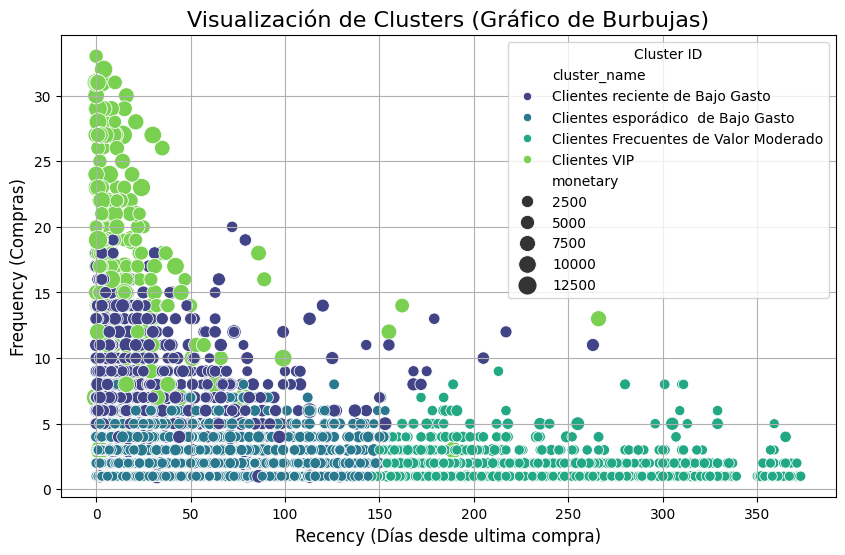

In [288]:
# Crear gráfico de burbujas
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm,
    x='recency',
    y='frequency',
    size='monetary',
    hue='cluster_name',
    palette='viridis',
    sizes=(50, 200),  #
    legend='brief'
)

# Etiquetas y título
plt.title('Visualización de Clusters (Gráfico de Burbujas)', fontsize=16)
plt.xlabel('Recency (Días desde ultima compra)', fontsize=12)
plt.ylabel('Frequency (Compras)', fontsize=12)
plt.legend(title='Cluster ID', fontsize=10, loc='upper right')
plt.grid(True)
plt.show()

 * ¿Cómo y para qué se utilizan los métodos deSilhouette Score y Calinski Harabrasz?

* Los métodos Silhouette Score y Calinski-Harabasz Index (CHS) son herramientas utilizadas para evaluar la calidad de la agrupación (clustering) y ayudan a determinar el número adecuado de clusters en un modelo de clustering no supervisado como K-Means.


* El Silhouette Score: 

- Mide qué tan bien se ajustan los puntos dentro de su propio cluster en comparación con otros clusters.
- Evaluación de calidad: El Silhouette Score permite evaluar si la asignación de los puntos a los clusters es adecuada.
- Selección del número de clusters: Un valor más alto de Silhouette Score generalmente indica una mejor calidad de los clusters. Se puede usar para comparar diferentes números de clusters y seleccionar el mejor.

* Alinski-Harabasz Index (CHS):

 -  El Calinski-Harabasz Index (también conocido como el índice de la varianza entre y dentro de los clusters) evalúa la dispersión de los clusters. En términos simples, mide la relación entre la varianza dentro de los clusters y la varianza entre los clusters.
 - Evaluación de la calidad del clustering: Un valor más alto de CHS sugiere que los clusters son más compactos y están bien separados.
 - Selección del número de clusters: Similar al Silhouette Score, se puede usar para determinar el número óptimo de clusters.


* Utilizacion:

* En el código a continuacion , ambos métodos se calculan para diferentes valores de k (el número de clusters) en el rango de 2 a 9. Esto se realiza para evaluar la calidad del clustering para cada posible número de clusters y elegir el número óptimo de clusters basándose en las métricas:

* Distorsión: Mide la suma de las distancias de los puntos a su centroide más cercano. Es un indicador de la "compacidad" del clustering.
* Inercia: Mide la suma de las distancias cuadradas de los puntos a su centroide.
* Silhouette Score: Ayuda a evaluar qué tan bien están definidos los clusters.
* Calinski-Harabasz Score: Proporciona una medida de la separación entre los clusters.

In [289]:
K = range(2,10)
distortions = []
inertias = []
sil_score = []
chs_score = []

for k in K:
    # Inicializar KMeans con k clusters
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(rfm_scaled)
    
    # Calcular la distorsión (inercia) y la silueta
    distortions.append(sum(np.min(cdist(rfm_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / rfm_scaled.shape[0])
    inertias.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
    sil_score.append(silhouette_score(rfm_scaled, cluster_labels))
    chs_score.append(chs(rfm_scaled, cluster_labels))



# Graficamos los resultados de la evaluación de diferentes valores de K

   K  Silhouette Score  Calinski-Harabasz Score  Distortion      Inertia
0  2          0.544345              3075.508787    1.134796  7380.817796
1  3          0.509744              4357.272748    0.813355  4167.822344
2  4          0.482007              4621.131862    0.693999  2981.966023
3  5          0.435205              4295.030353    0.640650  2519.934601
4  6          0.415864              4241.075425    0.575129  2120.739065
5  7          0.367549              3749.226504    0.586800  2018.010889
6  8          0.383034              3974.532338    0.519137  1682.780941
7  9          0.382461              4040.796883    0.500367  1474.796407


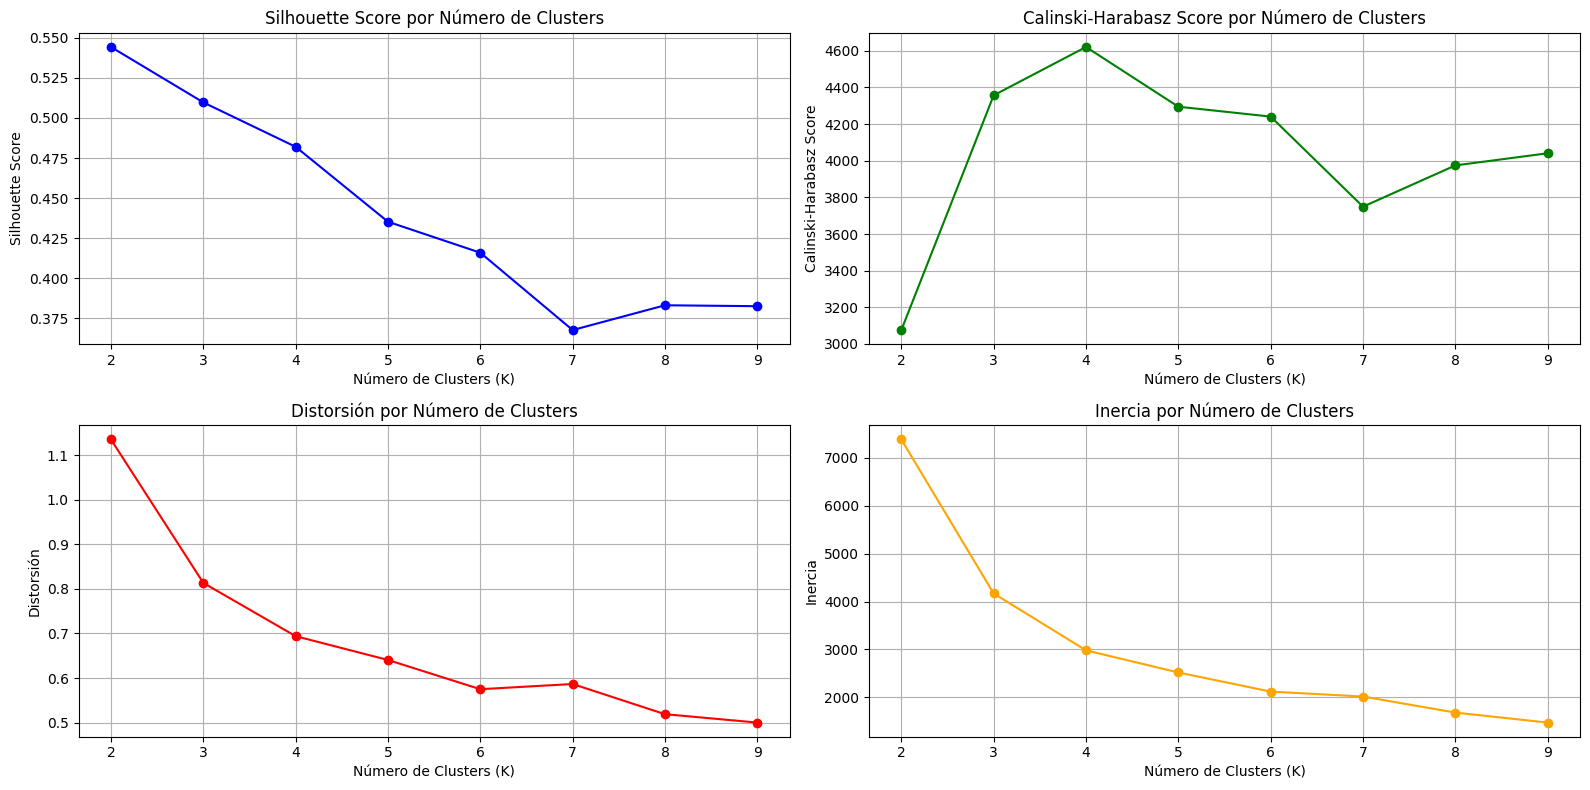

In [290]:
# Crear un DataFrame con los resultados de las métricas
results = pd.DataFrame({
    'K': K,  # Rango de números de clusters
    'Silhouette Score': sil_score,
    'Calinski-Harabasz Score': chs_score,
    'Distortion': distortions,
    'Inertia': inertias
})

# Imprimir la tabla con los resultados
print(results)

# Crear gráficos para visualizar los resultados
plt.figure(figsize=(16, 8))

# Subplot 1: Silhouette Score
plt.subplot(2, 2, 1)
plt.plot(K, sil_score, marker='o', color='b', label='Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Subplot 2: Calinski-Harabasz Score
plt.subplot(2, 2, 2)
plt.plot(K, chs_score, marker='o', color='g', label='Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score por Número de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)

# Subplot 3: Distortion
plt.subplot(2, 2, 3)
plt.plot(K, distortions, marker='o', color='r', label='Distortion')
plt.title('Distorsión por Número de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Distorsión')
plt.grid(True)

# Subplot 4: Inertia
plt.subplot(2, 2, 4)
plt.plot(K, inertias, marker='o', color='orange', label='Inercia')
plt.title('Inercia por Número de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.grid(True)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

# Interpreación de los resultados de la evaluación de diferentes valores de K

* Distorsión e Inercia: Ambos valores tienden a disminuir conforme aumentas k, ya que al agregar más clusters, los puntos se agrupan más cerca de sus centroides. Sin embargo, esto no significa necesariamente que más clusters sean mejores, ya que se puede estar sobreajustando el modelo.

* Silhouette Score y Calinski-Harabasz Score: Estas métricas no siempre siguen el mismo patrón que la distorsión y la inercia. Pueden ayudarte a identificar un número k en el que la calidad del clustering es óptima.

* Silhouette Score:El valor de la métrica varía entre -1 y 1:
 1: El punto está bien agrupado y alejado de los otros clusters.
 0: El punto está en el límite entre dos clusters.
 -1: El punto podría estar mal clasificado, ya que está más cerca de otro cluster que del suyo propio.

* Calinski-Harabasz Score:
 -Valor alto de Calinski-Harabasz: Un valor alto indica que los clusters están bien separados y tienen una baja dispersión interna. Un aumento en el Calinski-Harabasz Score a medida que aumentas k es generalmente un buen indicio de que la calidad del clustering está mejorando.

 -Valor bajo de Calinski-Harabasz: Si el Calinski-Harabasz Score es bajo o no mejora significativamente con el aumento de k, podría indicar que los clusters no están bien separados, incluso si la distorsión o la inercia disminuyen.

Como se explico en clases por profesor tambien podemos emplear la técnica del codo para seleccionar la cantidad de clusters,
la regla del codo observa cómo cambia la distorsión (o inercia) a medida que aumenta el número de clusters k. A medida que aumentas k, la distorsión disminuye porque los puntos están más cerca de sus centroides. Sin embargo, después de cierto número de clusters, la disminución de la distorsión se vuelve más lenta. Este punto de inflexión en la curva de distorsión se asemeja a un "codo", y ese es el número de clusters que generalmente se selecciona como óptimo.

* Cómo aplicar la regla del codo:
Distorsión o inercia: A medida que aumentas k, la distorsión disminuye. Después de cierto valor de k, la disminución es más gradual, lo que indica que añadir más clusters no mejora significativamente el modelo. El "codo" es el punto donde la pendiente de la curva cambia de manera significativa.

* ¿Cómo identificar el "codo"?
Grafica la distorsión o la inercia en función del número de clusters k.Busca el punto de inflexión en la curva, que se ve como un "codo". Este es el número de clusters óptimo.

* ¿Cuáles son las principales diferencias entre Single, Complete y Average Linkage en **HAC**?

Diferencias:

* Definicion entre Clusters:
    - Single Linkage:
        La distancia entre dos clusters se define como la distancia mínima entre cualquier par de puntos de los dos clusters.

    - Complete Linkage:
        La distancia entre dos clusters se define como la distancia máxima entre cualquier par de puntos de los dos clusters.

    - Average Linkage:
        La distancia entre dos clusters se define como la distancia promedio entre todos los puntos de los dos clusters.

* Comportamiento de la Fusión de Clusters:
    - Single Linkage:
        Tiende a fusionar clusters rápidamente si existe una distancia muy cercana entre algún par de puntos.
        Los clusters pueden aparecer en forma de "cadenas" o estructuras alargadas.
    
    - Complete Linkage:
        Fusiona los clusters de manera más lenta porque toma en cuenta la distancia máxima, lo que requiere que todos los puntos dentro de los clusters estén relativamente cerca entre sí para que los clusters se fusionen.
        Los clusters tienden a ser más compactos.
    
    - Average Linkage:
        El comportamiento es un intermedio entre Single y Complete Linkage.
        Fusiona los clusters de una manera que trata de equilibrar la distancia promedio de todos los puntos entre los clusters.







In [291]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram



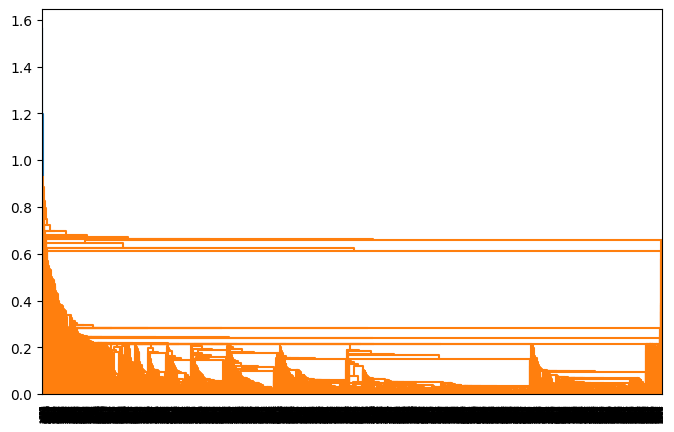

In [292]:
# Single linkage: 


mergings = linkage(rfm_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

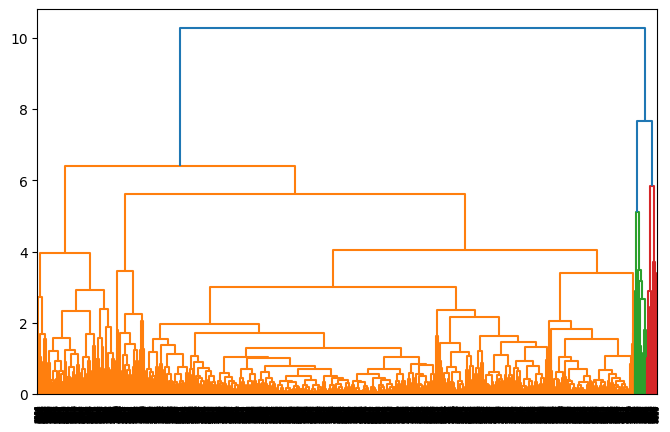

In [293]:

mergings = linkage(rfm_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

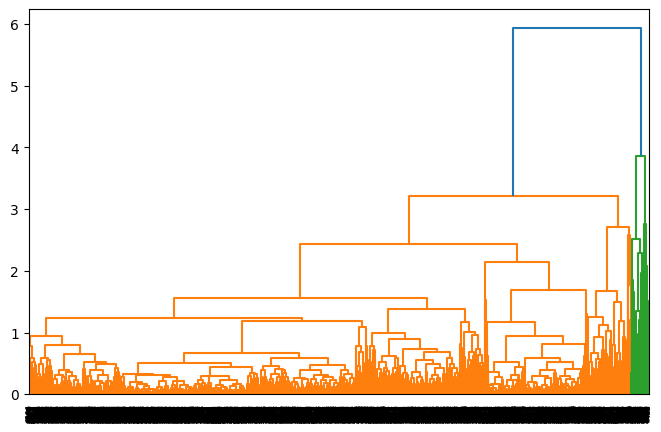

In [294]:

mergings = linkage(rfm_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

* ¿Qué tan diferentes son los resultados entre ambos métodos K-means vs HAC?

    Respuesta:
    Al implementar HAC notamos que a pesar de no tener que especificar un K para la cantidad de clusters, en el metodo  HAC Complete Linkage y Average se pudieron aprecieran 3 segmentos de clientes con una distribución parecida al K-means con k=3, solo que se ve un poco mas definido el cluster en la agrupación de los clientes. 

    A continuación se comapran los resultados entre ambos metodos


In [295]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Modelo K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(rfm_scaled)

# Modelo HAC con método 'complete'
hac_linkage = linkage(rfm_scaled, method='average', metric='euclidean')
hac_labels = fcluster(hac_linkage, t=3, criterion='maxclust')  # 3 clusters


In [296]:
print(type(rfm_scaled))
print(rfm_scaled.shape)

<class 'pandas.core.frame.DataFrame'>
(4244, 3)


In [297]:
if isinstance(rfm_scaled, pd.DataFrame):
    rfm_scaled_numpy = rfm_scaled.values  # Convierte DataFrame a NumPy array


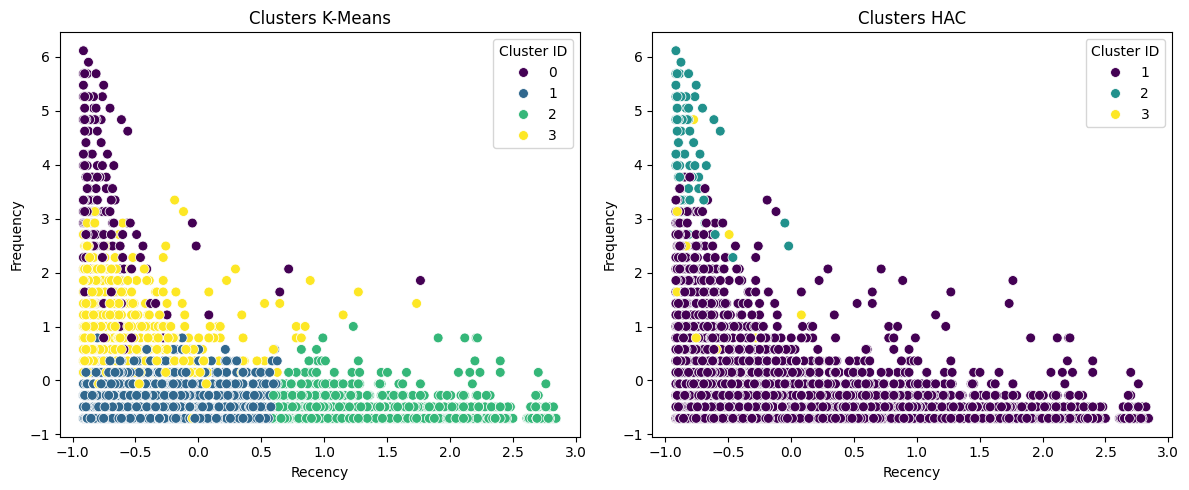

In [298]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico para K-Means
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=rfm_scaled_numpy[:, 0], y=rfm_scaled_numpy[:, 1], hue=kmeans_labels, palette='viridis', s=50
)
plt.title('Clusters K-Means')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster ID')

# Gráfico para HAC
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=rfm_scaled_numpy[:, 0], y=rfm_scaled_numpy[:, 1], hue=hac_labels, palette='viridis', s=50
)
plt.title('Clusters HAC')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster ID')

plt.tight_layout()
plt.show()


In [299]:
sil_kmeans = silhouette_score(rfm_scaled, kmeans_labels)
sil_hac = silhouette_score(rfm_scaled, hac_labels)

print(f"Silhouette Score - K-Means: {sil_kmeans}")
print(f"Silhouette Score - HAC: {sil_hac}")


Silhouette Score - K-Means: 0.4820071357425771
Silhouette Score - HAC: 0.6696760824953244


In [300]:
* Silhouette Score de K-Means (0.482): Un puntaje cercano a 0.5 indica que los clusters están razonablemente bien definidos, pero podría haber solapamientos o puntos cercanos a los bordes de otros clusters.

SyntaxError: invalid syntax (1186479022.py, line 1)

* Silhouette Score de K-Means (0.482):Un puntaje cercano a 0.5 indica que los clusters están razonablemente bien definidos, pero podría haber solapamientos o puntos cercanos a los bordes de otros clusters.
* Silhouette Score de HAC (0.66): Esto sugiere que los clusters jerárquicos están mejor separados y tienen una mayor cohesión interna.


* ¿Los clientes quedan categorizados en el mismo cluster que en otro? 

    Respuesta:
    No, los clientes no quedan categorizados de manera idéntica entre los dos métodos. Por ejemplo:
    En Recency, el modelo K-Means divide los clientes con valores bajos en dos clusters, lo que permite una segmentación más detallada de clientes recientes. Esto puede ser útil si se desea identificar subgrupos dentro de este comportamiento.
    Para clientes VIP (alta frecuencia y monetary), ambos métodos tienden a generar clusters similares. Sin embargo, el agrupamiento en HAC es más compacto, lo que sugiere una mayor cohesión interna de estos clusters.
    
    
   Por lo que se ve HAC genera una segmentación más precisa desde el punto de vista matemático, con clusters bien separados según el Silhouette Score (0.670). Sin embargo, la segmentación puede ser más difícil de interpretar o utilizar en términos comerciales, ya que algunos grupos estan muy fragmentados.

    K-Means (k=4) ofrece clusters que, aunque menos cohesionados (Silhouette Score = 0.482), son más fáciles de asociar con nombres o comportamientos de clientes.
    Por lo tanto, para un análisis de negocio, K-Means con k=4 puede ser más práctico y accionable, mientras que HAC se ve más útil si se busca una segmentación más precisa.
        
* ¿Hay diferencias en el tiempo de ejecución?

    Si Kmean fue mucho mas rapido en las ejecuciones mientras que HAC demoro mas. Esto tambien debido a que HAC  Es considerablemente más costoso a nivel computacional  debido al cálculo iterativo de la matriz de distancias para fusionar los clusters. 

3 .- (40%) Implemente la detección de outliers en el dataframe `rfm` con DBSCAN, siguiendo los ejemplos de los links siguientes. 
* Ejemplo: http://exponentis.es/ejemplo-de-uso-de-dbscan-en-python-para-deteccion-de-outliers
* Ejemplo: https://www.datatechnotes.com/2020/04/anomaly-detection-with-dbscan-in-python.html
* ¿Qué tan diferentes son los resultados respecto a la detección de outliers utilizando ***interquartile range***?

In [301]:
rfm_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4244 entries, 0 to 4243
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    4244 non-null   float64
 1   frequency  4244 non-null   float64
 2   monetary   4244 non-null   float64
dtypes: float64(3)
memory usage: 99.6 KB


# Normalización de datos con MinMaxScaler

In [302]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_scaled)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['recency', 'frequency', 'monetary'])


In [155]:
rfm_scaled.head()

,recency,frequency,monetary
0,0.002681,0.18750,0.315114
1,0.198391,0.09375,0.131400
2,0.048257,0.00000,0.128499
3,0.828418,0.00000,0.024449
4,0.093834,0.31250,0.112988


# Aplicación de DBSCAN (eps = 0.08, min_samples = 5)

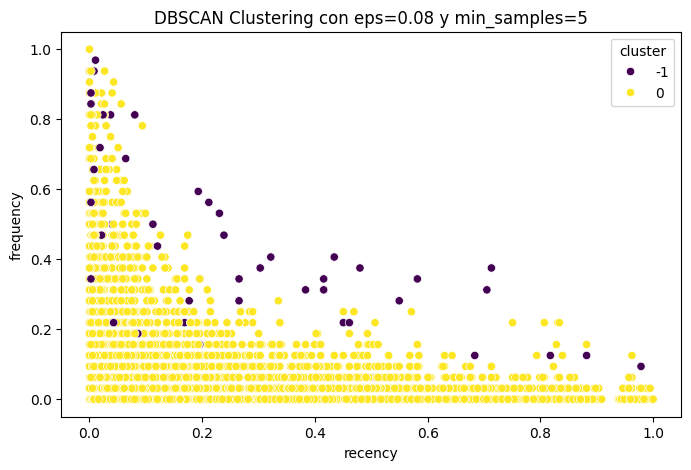

In [304]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.08, min_samples=5)
rfm_scaled['cluster'] = dbscan.fit_predict(rfm_scaled)

# Visualizar los clústeres
sns.scatterplot(data=rfm_scaled, x='recency', y='frequency', hue='cluster', palette='viridis')
plt.title("DBSCAN Clustering con eps=0.08 y min_samples=5")
plt.show()


# Parametrización con la técnica del codo (Curva Elbow)


* Iportando librerias

In [172]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import kneighbors_graph


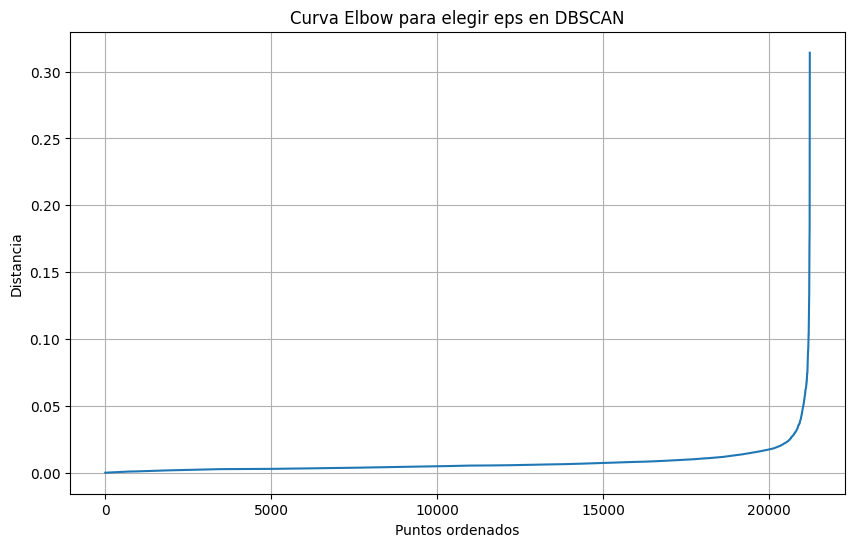

In [305]:

# 1. Reducir dimensionalidad con PCA
estimator = PCA(n_components=2)
X_pca = estimator.fit_transform(rfm_scaled[['recency', 'frequency', 'monetary']])

# 2. Calcular la matriz de distancias euclidianas
matsim = euclidean_distances(X_pca)

# 3. Generar el grafo de vecinos cercanos (kneighbors_graph)
minPts = 5  # Fijamos el parámetro minPts
A = kneighbors_graph(X_pca, minPts, include_self=False)
Ar = A.toarray()

# 4. Extraer y ordenar las distancias a los vecinos más cercanos
seq = []
for i, s in enumerate(X_pca):
    for j in range(len(X_pca)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])
seq.sort()

# 5. Visualizar la curva para elegir eps
plt.figure(figsize=(10, 6))
plt.plot(seq)
plt.title("Curva Elbow para elegir eps en DBSCAN")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia")
plt.grid()
plt.show()



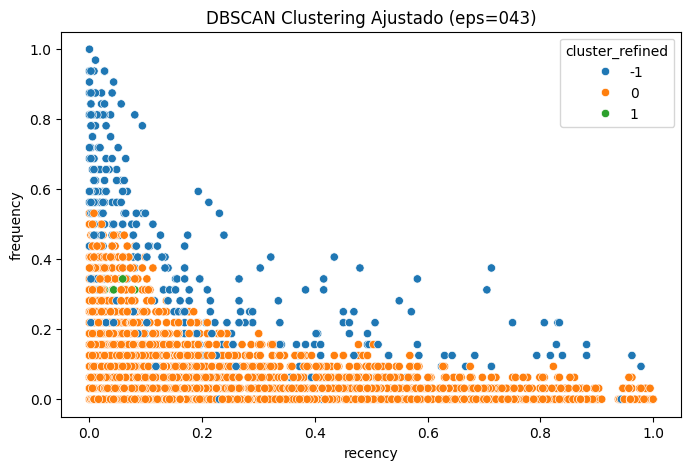

In [351]:
# Aplicar DBSCAN con valores ajustados
dbscan_refined = DBSCAN(eps=0.043, min_samples=10)
rfm['cluster_refined'] = dbscan_refined.fit_predict(rfm_scaled[['recency', 'frequency', 'monetary']])

# Visualizar los clústeres refinados
sns.scatterplot(data=rfm_scaled, x='recency', y='frequency', hue='cluster_refined', palette='tab10')
plt.title("DBSCAN Clustering Ajustado (eps=043)")
plt.show()


* Clúster -1: son los puntos azul oscuros, valores poco densos que DBSCAN interpreta como outliers.
* Clúster 0: de color rosa oscuro, son los datos más densos -y por tanto normales- de la curva.
* Clúster 1: de color amarillo, es un pequeño grupo que no pertenece al clúster 0 pero no tienen porqué ser valores anómalos.

# Recuento de outliers


In [353]:
# Recuento de outliers
outliers_count = (rfm['cluster_refined'] == -1).sum()
print(f"Número de outliers detectados: {outliers_count}")

Número de outliers detectados: 402


In [355]:
# Mostrar el promedio,cantidad de records  agrupado cluster_refined 
rfm.groupby('cluster_refined').agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean', 'customerid': 'count'}).reset_index()

,cluster_refined,recency,frequency,monetary,customerid
0,-1,68.385572,12.621891,4838.461744,402
1,0,93.316889,3.406943,897.289048,3831
2,1,17.818182,11.090909,5598.362727,11


* Como resultado tenemos 402 Clientes que fueron detectados como outliers.

¿Qué tan diferentes son los resultados respecto a la detección de outliers utilizando ***interquartile range***?


La diferencia entre los resultados de la detección de outliers usando IQR y DBSCAN radica en sus enfoques:

IQR se basa en la distribución global de los datos, considerando outliers aquellos puntos que están fuera del rango intercuartílico (es decir, mas alla de 1.5 veces el IQR por debajo de Q1 o por encima de Q3). Esto no tiene en cuenta la densidad local de los puntos, por lo que un valor extremo puede ser marcado como outlier sin importar su proximidad a otros puntos.

DBSCAN, en cambio, identifica outliers basándose en la densidad local de los puntos. Los puntos en regiones de baja densidad son clasificados como outliers (Clúster -1), incluso si no son extremos según el IQR. Los puntos más densos forman clústeres, y los puntos en áreas menos densas pueden ser considerados outliers aunque no sean extremos.

Resumen: Los resultados de DBSCAN pueden diferir del IQR, ya que este último identifica outliers solo por su posición en la distribución de los datos, mientras que DBSCAN los detecta en función de la densidad local. Por lo tanto, los puntos identificados como outliers por DBSCAN pueden no serlo según IQR, y viceversa. En nuetro caso la segmetación de clientes permite identificar grupos de clientes que pueden ser outliers e impactar el modelo.